# "RIMM" Strategy


-----------------------------------------------------------------------------------------------
    
RIMM denotes the reaction of individual stock price movement to multiple markets' performance.

RIMM quantifies the relation between individual stock price and Stock Index, FX Rate, Commodities Index, and Bitcoin.



RIMM is not mature and requires improvements.

    
## Strategy construction

-----------------------------------------------------------------------------------------------



* Variable setting:
 - $RS_{(i,t)}$: daily return of stock i on trading day t. 
 
 - $RI_{(t)}$: daily return of Stock Index on trading day t. 
 
 - $RF_{(t)}$: daily return of FX rate on trading day t. 
 
 - $RC_{(t)}$: daily return of Commodities Index on trading day t. 
 
 - $RB_{(t)}$: daily return of Bitcoin on trading day t. 
 
 - $RIMM_{(i,t)}$: the RIMM for stock i on trading day t.
 


* Using N-day forward of data to get OLS coefficient ($\hat{\alpha_i}$ and $ \hat{\beta_{i}}$)


* Rolling OLS


* With the variables above, we can construct a linear model for stock i shown below


$$RS_{(i,t)} = \hat{\alpha_i} + \hat{\beta_{1i}}RI_{(i,t-1)} + \hat{\beta_{2i}}RF_{(i,t-1)} + \hat{\beta_{3i}}RC_{(i,t-1)} + \hat{\beta_{4i}}RB_{(i,t-1)} + \epsilon_i$$


where t = 1,2,…,N, implying that we are using last N trading dayes data to calibrate coefficients.


* With the coefficients calibrated, we use the formula below to calculate RIMM(i,t) for stock i on trading day t.

$$RIMM_{(i,t)} = \hat{\alpha_i} + \hat{\beta_{1i}}RI_{(i,t)} + \hat{\beta_{2i}}RF_{(i,t)} + \hat{\beta_{3i}}RC_{(i,t)} + \hat{\beta_{4i}}RB_{(i,t)}$$
    
A stock with higher RIMM(i,t) is better to a long position next day; while a stock i with lower RIMM(i,t) is better to a short position next day.

## Performance

-----------------------------------------------------------------------------------------------

* RIMM is relatively effective in Chinese all A shares.


* Shape ratio around 1


* performance not sensitive to length of rolling days 



In [10]:
import pandas as pd
import numpy as np
import os
import time
import datetime
import pickle
import matplotlib.pyplot as plt

### 1. Data feed

    Download data from Wind, Yahoo API and save them as pickle, for convenience in python data fetching.

In [11]:


class ComponentBase(object):

    def __init__(self, path, market):
        self.path = os.path.join(path, market)
        self._data = self.datafeed(market)
        self._stock_data_tradeday = self.get_data_by_field('close').index.astype('int')
        self._stock_data_symbols = self.get_data_by_field('close').columns.astype('string')

    def datafeed(self, market):
        os.chdir(self.path)
        with open(market + '.pickle', 'rb') as f:
            data_dict = pickle.load(f)
        return data_dict

    def get_data_by_field(self, field):
        return self._data[field]

    def data_preprocessing(self, data):
        data = data.reindex(self._stock_data_tradeday).replace(0., np.nan)
        return self.check_symbols(data)

    def check_symbols(self, df):
        symbols = df.columns
        diff = set(self._stock_data_symbols) - set(symbols)
        for key in diff:
            df[key] = np.nan
        return df[self._stock_data_symbols]

### 2. Strategy construction
    

In [12]:


class Strategy(ComponentBase):

    def __init__(self, path, test_market):
        super(Strategy, self).__init__(path, test_market)

    def calc_vwap(self):
        adj_factor = self.get_data_by_field('adj_factor')
        adj_factor.fillna(method='pad', inplace=True)
        volume = self.get_data_by_field('volume')
        amount = self.get_data_by_field('amount')
        vwap = amount / volume
        return vwap * adj_factor

    def get_return_val(self, data):
        ret = data / data.shift(1) - 1
        return ret.values

    def get_linear_parameter(self, x, y):
        b = np.linalg.solve(x.transpose().dot(x), x.transpose().dot(y))
        return b

    def calc_strategy(self, window):
        dep_var_needed = {'bitcoin', 'fx_rate', 'commodity', 'index'}
        dep_var_val = {key: val.reindex(self._stock_data_tradeday) for key, val in self._data.items() if key in dep_var_needed}
        dep_var_ret = {key: self.get_return_val(val) for key, val in dep_var_val.items()}

        vwap = self.calc_vwap()
        ret_vwap = vwap / vwap.shift(1) - 1        
        ret_vwap = ret_vwap.values

        factor = pd.DataFrame(np.nan, index=self._stock_data_tradeday, columns=self._stock_data_symbols)
        factor_val = factor.values
        for day in range(factor.shape[0]):
            if day > window:
                dep_ret_roll = {key: val[day - window:day].flatten() for key, val in
                                dep_var_ret.items()}  # t-1 predictors

                indicator = [val[day] for key, val in dep_var_ret.items()]
                indicator.append(1.)
                indicator = np.hstack(indicator)

                not_nan_signal = [~np.isnan(val).any() for key, val in dep_ret_roll.items()]
                not_nan_signal.append(True)

                for sym in range(factor.shape[1]):
                    ret_vwap_roll = ret_vwap[day - window+1:day+1, sym]  # t ret_vwap
                    x = np.vstack([[val for key, val in dep_ret_roll.items()], np.asarray([1.] * window)]).T

                    b = self.get_linear_parameter(x[:, not_nan_signal], ret_vwap_roll)
                    factor_val[day, sym] = indicator[not_nan_signal].dot(b)
        return factor


def test():
    # path = os.path.abspath('../')
    path = r'E:\jupyter_notebook\jupyter\project_lj'
    s = Strategy(path, 'China')
    factor = s.calc_strategy(window=60)
    factor.to_csv(os.path.join(s.path,'rimm.csv'))
    print factor.tail()


if __name__ == '__main__':
    test()

                 1         2   4         5         6         7   8         9  \
20181112  0.007414  0.003941 NaN  0.011022  0.008423  0.005609 NaN  0.006205   
20181113  0.010772  0.006102 NaN  0.016165  0.010233  0.012167 NaN  0.007675   
20181114 -0.014879 -0.010751 NaN -0.007447 -0.005410 -0.009054 NaN  0.001683   
20181115 -0.000042  0.000840 NaN  0.008412  0.009692  0.001975 NaN  0.013284   
20181116 -0.005948 -0.002585 NaN  0.000318  0.004217 -0.008348 NaN  0.009288   

                10        11  ...   601162  2940  2939  300674  300751  \
20181112  0.003192  0.012423  ...      NaN   NaN   NaN     NaN     NaN   
20181113  0.004949  0.015860  ...      NaN   NaN   NaN     NaN     NaN   
20181114  0.003263 -0.002826  ...      NaN   NaN   NaN     NaN     NaN   
20181115  0.005607  0.009090  ...      NaN   NaN   NaN     NaN     NaN   
20181116  0.000346 -0.002704  ...      NaN   NaN   NaN     NaN     NaN   

          603220  601319  2941  603187  2943  
20181112     NaN     NaN   

### 3. Backtesting
    
Do backtesting by follwing process:
    
##### 3.1 get tradeble sign

Eliminate:

* st(only in Chinese market)
* suspension(volume==0)
* just released(IPO in the last 60 day)    
    
##### 3.2 neutral RIMM by market value


##### 3.3 collect return 

* Divide market-wide stocks into 10 groups based on RIMM values. 
* All these 10 groups return and a Long-Short portfolio's return are collected. 
* Hedge group0 by index, collecting the hedge result as well.
    
##### 3.4 summary RIMM strategy's performance

* annual and all period's return
* sharp ratio
* max drawdown

##### 3.5 plot 

* group 0-9 return
* cumulative sum of Long-Short return
* cumulative sum of hedge_index return
    
##### 3.6 RIMM in multiple countries 

equity market

* China all A shares ( about 3500 stocks )
* US ( S&P500 )
* HK ( wind hisindex 493 stocks )
    
##### 3.7 parameter adjustment

We do the OLS using N-day forward of data rollingly. In order to find a better rolling period, we test

* 30-days
* 60-days
* 90-days

in all three countries respectively. 
    

In [25]:
from universe import * 
from neutral import *
from collect_return import *
from test import *


def main(test_market, window):
    start = time.time()
    ext_path = os.path.join(r"D:\project\result", test_market+"_"+str(window)+"_days")
    os.mkdir(ext_path)
    ft = FactorTest(test_market)
    s = Strategy(test_market)    
    factor = s.calc_strategy(window = window)
    factor.to_csv(os.path.join(ext_path, "factor_"+str(window)+".csv"))
    
    # There are too much data and need a lot of time to run the strategy.This is only used in debug.
    # factor = pandas.read_csv(os.path.join(ext_path, "factor_"+str(window)+".csv"), index_col=0, header=0)    
    print "run time", time.time() - start    
    ret, summary, sum_annual = ft.run(window=10, factor=factor, path=ext_path)
    ft.plot_test(ret, path=ext_path)
    #sum_annual.to_csv(os.path.join(ext_path, "sum_annual.csv"))
    print sum_annual
    

##### 3.6 RIMM in multiple countries 
        

run time 602.351000071
test time 7.97699999809
         return  sharpe_ratio    max_dd
2008   0.124824      0.600847  0.125881
2009   0.186022      1.251867  0.091507
2010   0.126307      0.761387  0.088802
2011   0.141015      1.179403  0.076566
2012   0.241613      1.899245  0.094621
2013   0.216871      1.910045  0.056465
2014   0.151984      1.118823  0.064451
2015   0.492608      2.103295  0.121510
2016   0.150420      1.203090  0.059558
2017   0.083388      0.635851  0.078014
2018  -0.027461     -0.284484  0.058385
total  1.887591      1.109448  0.133187


<Figure size 432x288 with 0 Axes>

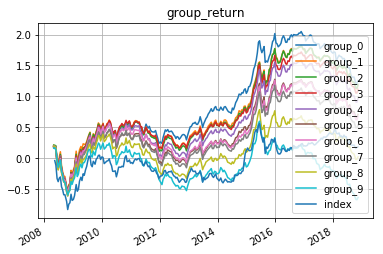

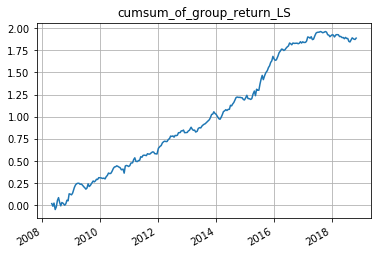

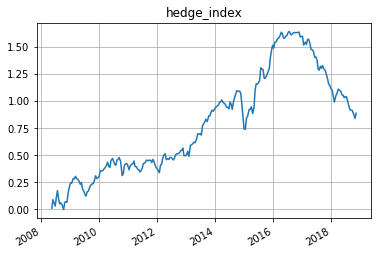

In [20]:
if __name__ == "__main__":
    %matplotlib inline 
    test_market = "China"
    window = 60    
    main(test_market, window) # in pycharm can use function 'argparser' for parameter adjustment        

run time 94.1890001297
test time 2.31199979782
         return  sharpe_ratio    max_dd
2008   0.126327      0.432798  0.240855
2009   0.178123      0.520998  0.242828
2010   0.151652      0.956691  0.081623
2011  -0.037740     -0.271137  0.070928
2012   0.047833      0.499371  0.051064
2013  -0.005313     -0.056954  0.044387
2014   0.019853      0.166943  0.065995
2015  -0.055888     -0.331162  0.106202
2016   0.062753      0.414540  0.103696
2017   0.016512      0.105177  0.086182
2018   0.202378      0.791104  0.181951
total  0.706491      0.323340  0.267513


<Figure size 432x288 with 0 Axes>

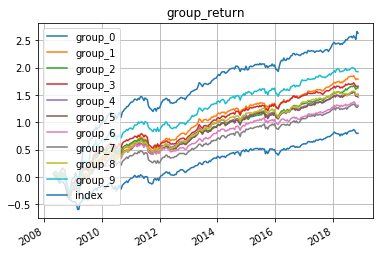

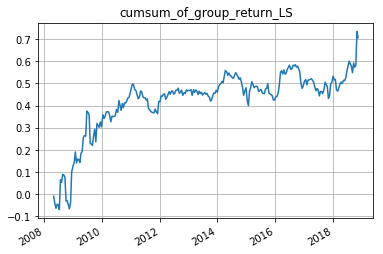

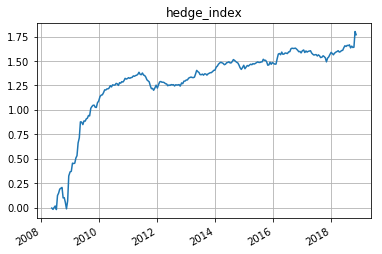

In [19]:
if __name__ == "__main__":
    %matplotlib inline 
    test_market = "US"
    window = 60
    main(test_market, window)

run time 97.5839998722
test time 2.63000011444
         return  sharpe_ratio    max_dd
2008  -0.016287     -0.054122  0.304945
2009  -0.210672     -0.738607  0.140500
2010   0.306067      1.559591  0.090491
2011   0.218051      1.264050  0.119624
2012  -0.077405     -0.343052  0.108012
2013   0.225073      1.414722  0.086881
2014   0.134856      0.596625  0.085705
2015  -0.072499     -0.202193  0.232075
2016  -0.011532     -0.087274  0.075224
2017   0.083943      0.584921  0.075618
2018   0.123015      0.643274  0.088836
total  0.702610      0.276784  0.312033


<Figure size 432x288 with 0 Axes>

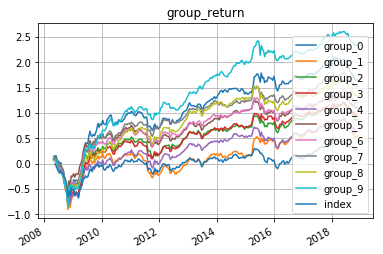

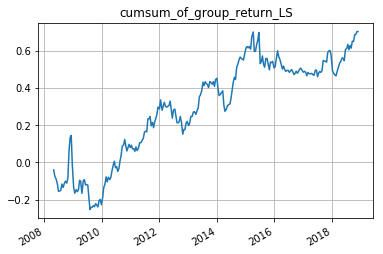

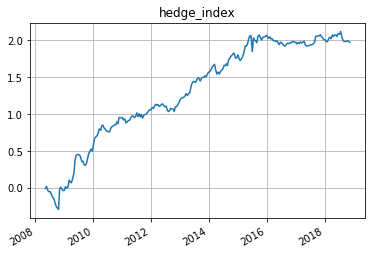

In [21]:
if __name__ == "__main__":
    %matplotlib inline 
    test_market = "HK"
    window = 60
    main(test_market, window)

##### 3.7 parameter adjustment   
    

run time 630.661999941
test time 7.2009999752
         return  sharpe_ratio    max_dd
2008   0.179314      0.945900  0.132776
2009   0.189849      1.139938  0.104194
2010   0.174629      0.955131  0.102993
2011   0.058299      0.462427  0.070405
2012   0.204707      1.708612  0.085618
2013   0.254572      2.211580  0.053513
2014   0.093166      0.728226  0.061940
2015   0.586809      2.593033  0.123754
2016   0.182557      1.533824  0.065017
2017   0.066064      0.405369  0.074723
2018  -0.032613     -0.381336  0.058402
total  1.957352      1.139742  0.132776


<Figure size 432x288 with 0 Axes>

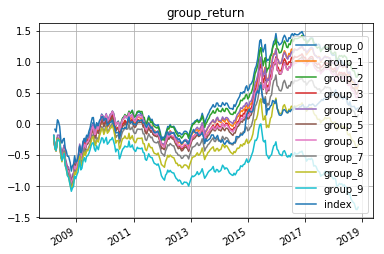

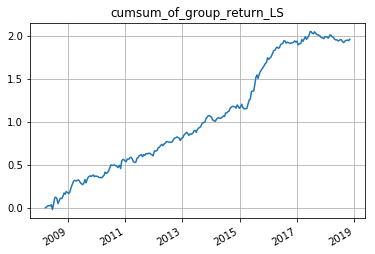

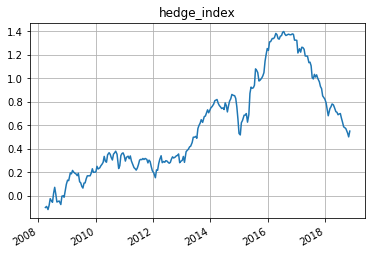

In [26]:
if __name__ == "__main__":
    %matplotlib inline 
    test_market = "China"
    window = 30
    main(test_market, window)

run time 97.9029998779
test time 2.33000016212
         return  sharpe_ratio    max_dd
2008   0.034036      0.117510  0.173723
2009   0.170092      0.432511  0.274276
2010  -0.004928     -0.045503  0.065341
2011   0.001942      0.014474  0.068364
2012  -0.058324     -0.403691  0.065824
2013   0.039851      0.399045  0.046139
2014   0.024133      0.205628  0.059637
2015   0.105986      0.624325  0.087229
2016   0.042648      0.263759  0.074924
2017  -0.040539     -0.322633  0.062639
2018  -0.169293     -0.741522  0.164468
total  0.145603      0.066416  0.326208


<Figure size 432x288 with 0 Axes>

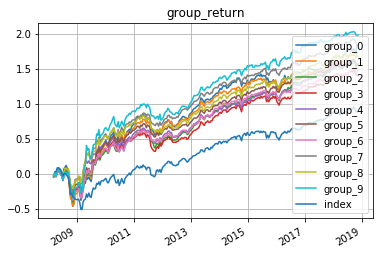

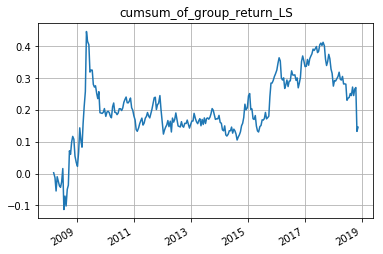

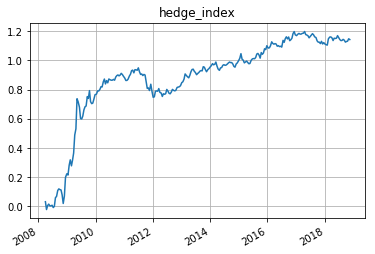

In [27]:
if __name__ == "__main__":
    %matplotlib inline 
    test_market = "US"
    window = 30
    main(test_market, window)

run time 86.0989999771
test time 2.257999897
         return  sharpe_ratio    max_dd
2008  -0.315344     -1.077979  0.239999
2009   0.043494      0.117324  0.224926
2010   0.213165      1.069868  0.096844
2011   0.190284      1.401525  0.058759
2012   0.038238      0.181044  0.102633
2013   0.163344      0.725538  0.114591
2014   0.072183      0.421796  0.078368
2015   0.005564      0.019908  0.144431
2016   0.081543      0.554126  0.087755
2017   0.217875      1.260114  0.082503
2018   0.186047      1.136831  0.078251
total  0.896393      0.358852  0.239999


<Figure size 432x288 with 0 Axes>

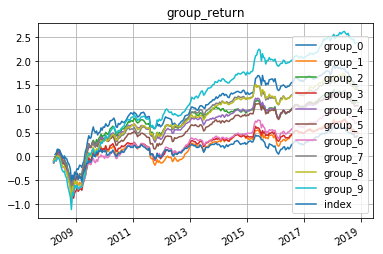

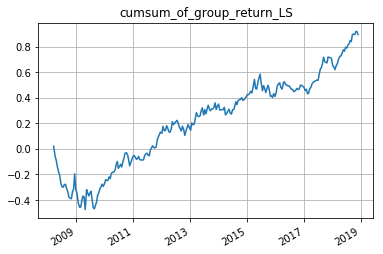

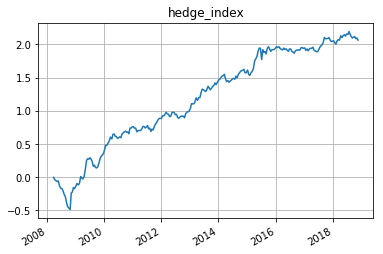

In [28]:
if __name__ == "__main__":
    %matplotlib inline 
    test_market = "HK"
    window = 30
    main(test_market, window)

run time 614.78399992
test time 7.63900017738
         return  sharpe_ratio    max_dd
2008   0.204015      1.218011  0.115167
2009   0.132792      0.728141  0.112992
2010   0.145765      0.845399  0.079837
2011   0.071454      0.567824  0.083317
2012   0.264526      2.109661  0.080987
2013   0.132105      1.177538  0.068070
2014   0.037622      0.327247  0.057274
2015   0.481408      2.401583  0.092934
2016   0.095849      0.896027  0.061318
2017   0.086067      0.757771  0.059022
2018  -0.016109     -0.191752  0.044949
total  1.635495      1.015677  0.129196


<Figure size 432x288 with 0 Axes>

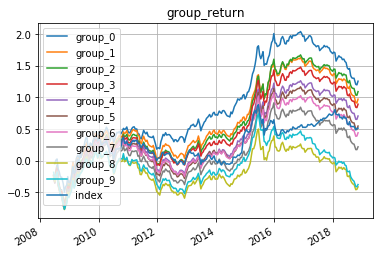

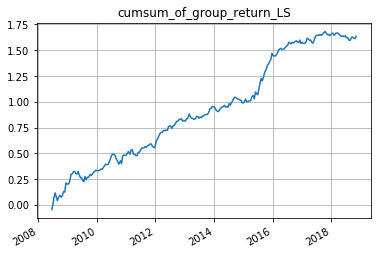

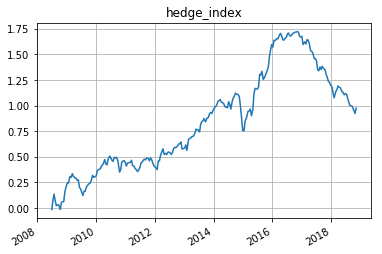

In [29]:
if __name__ == "__main__":
    %matplotlib inline 
    test_market = "China"
    window = 90
    main(test_market, window)

run time 99.1710000038
test time 2.47499990463
         return  sharpe_ratio    max_dd
2008   0.140696      0.629872  0.180478
2009   0.276682      0.636520  0.278928
2010   0.160897      1.039738  0.086416
2011  -0.016629     -0.126847  0.065019
2012   0.060181      0.518111  0.058009
2013  -0.005908     -0.059824  0.049456
2014   0.078486      0.586067  0.092168
2015  -0.049325     -0.288677  0.083217
2016  -0.009523     -0.042545  0.124130
2017  -0.009716     -0.054028  0.077271
2018   0.299264      1.144443  0.189812
total  0.925104      0.390428  0.278928


<Figure size 432x288 with 0 Axes>

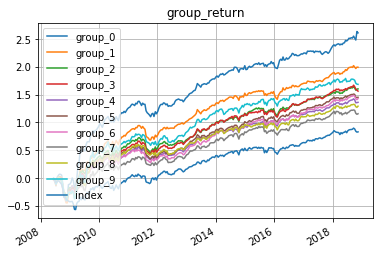

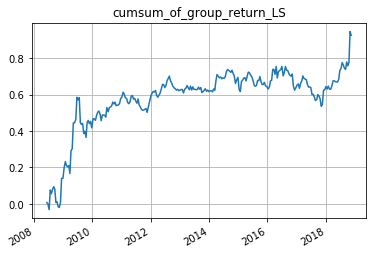

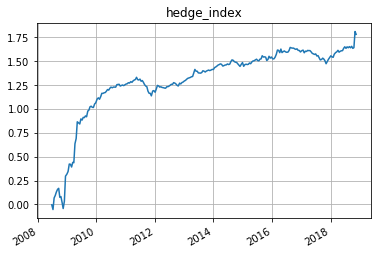

In [30]:
if __name__ == "__main__":
    %matplotlib inline 
    test_market = "US"
    window = 90
    main(test_market, window)

run time 98.6909999847
test time 2.35500001907
         return  sharpe_ratio    max_dd
2008   0.162912      0.504963  0.358271
2009   0.035657      0.094996  0.190545
2010   0.336438      1.625872  0.110324
2011   0.355923      1.967341  0.126949
2012  -0.063923     -0.299987  0.102288
2013   0.148501      0.733128  0.105014
2014   0.081230      0.338628  0.111529
2015  -0.137756     -0.396723  0.249670
2016   0.001821      0.015488  0.075683
2017   0.131134      0.979094  0.068322
2018   0.008173      0.051167  0.080299
total  1.060110      0.388489  0.367867


<Figure size 432x288 with 0 Axes>

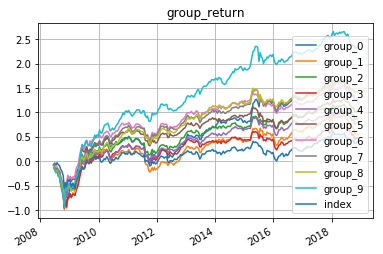

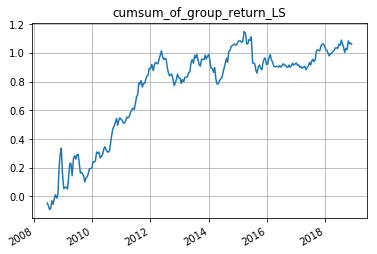

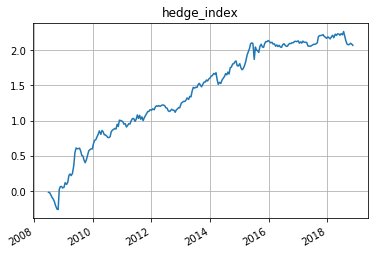

In [31]:
if __name__ == "__main__":
    %matplotlib inline 
    test_market = "HK"
    window = 90
    main(test_market, window)

### 4. Conclusion


* RIMM is relatively effective in Chinese all A shares.


* Shape ratio around 1


* Performance not sensitive to length of rolling days 


* Requires improvements


<p style="text-align:right">By Linjuan CUHKSZ </p>
<p style="text-align:right">20181207</p>